In [38]:
pip install lightgbm

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X_train = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/Extracted Features/mne/X.npy")
X_test = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/Extracted Features/mne/X_test.npy")
Y_train = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/Extracted Features/mne/Y.npy")
Y_test = np.load("/content/drive/MyDrive/2021_VIIT_P300_Session2 /Hackathon Oct 2021/Extracted Features/mne/Y_test.npy")
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((5670, 48), (3780, 48), (5670,), (3780,))

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
y_pred = logreg.predict(X_test)

In [8]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.55      0.84      0.66      2100
           1       0.41      0.14      0.20      1680

    accuracy                           0.53      3780
   macro avg       0.48      0.49      0.43      3780
weighted avg       0.49      0.53      0.46      3780



In [16]:
from sklearn.metrics import confusion_matrix

In [18]:

y_test_preds = logreg.predict(X_test)
cls1 = classification_report(Y_test,y_test_preds)
print(cls1)
print("------------COnfusion Matrix---------------")
confusion_matrix(Y_test,y_test_preds)

              precision    recall  f1-score   support

          -1       0.55      0.84      0.66      2100
           1       0.41      0.14      0.20      1680

    accuracy                           0.53      3780
   macro avg       0.48      0.49      0.43      3780
weighted avg       0.49      0.53      0.46      3780

------------COnfusion Matrix---------------


array([[1767,  333],
       [1453,  227]])

In [19]:
y_train_preds = logreg.predict(X_train)
cls1 = classification_report(Y_train,y_train_preds)
print(cls1)
print("------------COnfusion Matrix---------------")
confusion_matrix(Y_train,y_train_preds)


              precision    recall  f1-score   support

          -1       0.56      0.94      0.71      3150
           1       0.55      0.09      0.15      2520

    accuracy                           0.56      5670
   macro avg       0.56      0.51      0.43      5670
weighted avg       0.56      0.56      0.46      5670

------------COnfusion Matrix---------------


array([[2971,  179],
       [2303,  217]])

In [20]:
Y_test.shape, y_train_preds.shape

((3780,), (5670,))

In [31]:
# import matplotlib.pylpot as plt

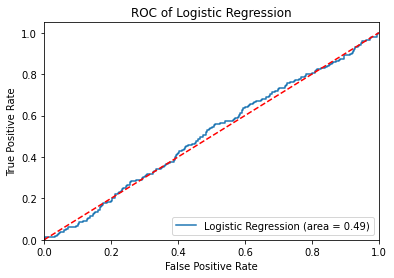

In [32]:
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

NOW LET's Apply LIGHTGBM 


In [40]:
import optuna


In [45]:
from sklearn.metrics import f1_score
def objective(trial) -> float:
    
    # joblib.dump(study, 'study.pkl')
    
    # train_X,test_X,train_y,test_y = train_test_split(X, Y, test_size = 0.30,random_state = 101)
    # dtrain = lgb.Dataset(X_train, label=y_train)
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
 
    
    lgbm = LGBMClassifier(**param,n_jobs=-1)
    lgbm.fit(X_train,Y_train)
    preds = lgbm.predict(X_test)
    pred_labels = np.rint(preds)
    Y_pred_proba = lgbm.predict_proba(X_test)
    r_roc_auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
    # f1 = f1_score(Y_test, preds, average=None,pos_label=1)
    # print(f1)
    # return f1[1]
    return r_roc_auc
    

In [56]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

[I 2021-10-18 06:29:51,282] A new study created in memory with name: no-name-c1cfedb4-42b7-4f55-ad90-0b78ae251b47
[I 2021-10-18 06:29:53,856] Trial 0 finished with value: 0.5104611678004535 and parameters: {'lambda_l1': 0.1248225592776761, 'lambda_l2': 4.2451922318972136e-05, 'num_leaves': 100, 'feature_fraction': 0.78530106615989, 'bagging_fraction': 0.9070070667615954, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 0 with value: 0.5104611678004535.
[I 2021-10-18 06:29:54,800] Trial 1 finished with value: 0.5433115079365078 and parameters: {'lambda_l1': 0.16922691493226305, 'lambda_l2': 0.2727692678242361, 'num_leaves': 227, 'feature_fraction': 0.5302546098012642, 'bagging_fraction': 0.4141341196762119, 'bagging_freq': 7, 'min_child_samples': 23}. Best is trial 1 with value: 0.5433115079365078.
[I 2021-10-18 06:29:55,588] Trial 2 finished with value: 0.5426170634920635 and parameters: {'lambda_l1': 0.00040051271192581605, 'lambda_l2': 6.437386144517874e-06, 'num_leaves': 1

In [57]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 300
Best trial: {'lambda_l1': 9.533012352847713e-08, 'lambda_l2': 7.504070744052783e-08, 'num_leaves': 2, 'feature_fraction': 0.5435509694126832, 'bagging_fraction': 0.913311816012022, 'bagging_freq': 7, 'min_child_samples': 86}


In [58]:
# best_params={'lambda_l1': 0.06770730346819898, 'lambda_l2': 0.022431428511784306, 'num_leaves': 94, 'feature_fraction': 0.8751672826088824, 'bagging_fraction': 0.6485349829513737, 'bagging_freq': 4, 'min_child_samples': 79}

In [59]:
best_params, tuning_history = dict(), list()
# booster = lgbm.train(params, dtrain, valid_sets=dval,
#                     verbose_eval=0,
#                     best_params=best_params,
#                     tuning_history=tuning_history)
 
print( best_params)
print( tuning_history)

{}
[]


In [60]:
best_params=study.best_trial.params

In [61]:
lgbm = LGBMClassifier(**best_params)
lgbm.fit(X_train,Y_train)

LGBMClassifier(bagging_fraction=0.913311816012022, bagging_freq=7,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.5435509694126832, importance_type='split',
               lambda_l1=9.533012352847713e-08, lambda_l2=7.504070744052783e-08,
               learning_rate=0.1, max_depth=-1, min_child_samples=86,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=2, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [62]:
X_train.shape,Y_train.shape

((5670, 48), (5670,))

In [63]:
y_train_preds = lgbm.predict(X_train)
cls1 = classification_report(Y_train,y_train_preds)
print(cls1)
print("------------COnfusion Matrix---------------")
confusion_matrix(Y_train,y_train_preds)

              precision    recall  f1-score   support

          -1       0.62      0.88      0.73      3150
           1       0.69      0.34      0.45      2520

    accuracy                           0.64      5670
   macro avg       0.66      0.61      0.59      5670
weighted avg       0.65      0.64      0.61      5670

------------COnfusion Matrix---------------


array([[2765,  385],
       [1674,  846]])

In [64]:
y_preds=lgbm.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
cls = classification_report(Y_test,y_preds)
print(cls)
print("------------COnfusion Matrix---------------")
confusion_matrix(Y_test,y_preds)


              precision    recall  f1-score   support

          -1       0.57      0.92      0.70      2100
           1       0.57      0.14      0.22      1680

    accuracy                           0.57      3780
   macro avg       0.57      0.53      0.46      3780
weighted avg       0.57      0.57      0.49      3780

------------COnfusion Matrix---------------


array([[1927,  173],
       [1453,  227]])

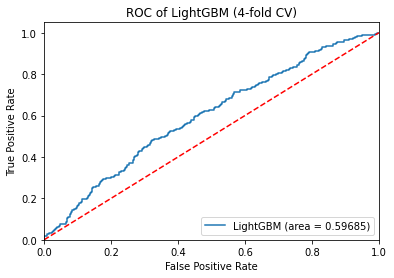

In [55]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict the probability of our label score
Y_pred_proba = lgbm.predict_proba(X_test)

r_roc_auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LightGBM (area = %0.5f)' % r_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of LightGBM (4-fold CV)')
plt.legend(loc="lower right")
# plt.savefig('images2/Randomforest_ROC')
plt.show()

In [ ]:
optuna.visualization.plot_param_importances(study)